In [1]:
from loadmodules import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.mixture import GaussianMixture
from matplotlib import ticker

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
def get_mass_age_metallicity(sim, snapshot=127, decomposition=False, init_mass_cut=False):
    sf = load_subfind(snapshot, dir=sim, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=sim, subfind=sf, hdf5=True, loadonlyhalo=0, loadonlytype=[4])
    s.calc_sf_indizes( sf )
    galrad = sf.data['frc2'][0]
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

    element = {'H':0, 'He':1, 'C':2, 'N':3, 'O':4, 'Ne':5, 'Mg':6, 'Si':7, 'Fe':8}
    elementnum = {'H':1, 'He':4, 'C':12, 'N':14, 'O':16, 'Ne':20, 'Mg':24, 'Si':28, 'Fe':56}
    #from Asplund et al. (2009) Table 5
    SUNABUNDANCES = {'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73, 'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54}
    for iel,val in enumerate(element):
        s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
        s.data[val+'/H'] -= (SUNABUNDANCES[val] - SUNABUNDANCES['H'])

    print('Redshift of the simulation: {:2.2f}'.format(s.redshift))

    starparts = (s.data['age']>0.) * (s.r()<galrad) * (s.data['subhalo']==0)
    mask_clusters_initial = (s.data['incl'][starparts] > 0 )
    feh_scs_i = np.repeat(s.data['Fe/H'][starparts], s.data['incl'][starparts]) - 0.5
    
    if decomposition:
        Lz = pylab.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
        orbital_energy = s.data['pot'] + 0.5 * np.sum(s.data['vel']**2, axis=1)
        jz = Lz[starparts]
        ii = np.argsort(orbital_energy[starparts])
        eps = jz[ii]
        npm = 50
        eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
        ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
        ilist = ilist[ii] # ilist=5,4,3,2,1
        resort = np.argsort(ilist) # resort=5,4,3,2,1
        eps = eps[resort] # eps2=5,4,3,2,1

        # Build feature array: [ε, Energy]
        X = np.vstack((eps,orbital_energy[starparts],
                        np.log10(np.abs(s.data['pos'][:,0][starparts])))).T

        # Fit GMM
        gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[starparts]), -2.0],
                                                        [0.9,np.median(orbital_energy[starparts]), -5.0]],
                                                        covariance_type='full', random_state=42)
        gmm.fit(X)

        # Predict cluster memberships
        decomp_labels = gmm.predict(X)
        median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
        sph_label = np.argmin(np.array(median_eps))
        disc_label = np.argmax(np.array(median_eps))

        # Force assign disc_label to clusters with high circularity parameter
        mask = (decomp_labels == sph_label) & (eps > 0.7)# & (s.r()[starparts] < np.percentile(s.r()[starparts][decomp_labels == disc_label], 0.5))
        decomp_labels[mask] = disc_label

        # Force assign sph_label to clusters with high z-coordinate (10kpc)
        mask = (decomp_labels == disc_label) & (np.abs(s.data['pos'][:,0][starparts])*1e3 > 5.)
        decomp_labels[mask] = sph_label
        labels_i = np.repeat(decomp_labels, s.data['incl'][starparts])
        mask_gc = (labels_i == sph_label)
    else:
        mask_gc = np.repeat(np.ones(starparts.sum(), dtype=bool), s.data['incl'][starparts])
    

    cluster_masses = 1e10*s.data['mclt'][starparts][mask_clusters_initial].flatten()
    init_cluster_masses = 1e10*s.data['imcl'][starparts][mask_clusters_initial].flatten()
    
    not_empty_clusters = (init_cluster_masses>0.)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]

    if init_mass_cut:
        mask_imass = init_cluster_masses > 1e5
    else:
        mask_imass = np.ones_like(init_cluster_masses, dtype=bool)

    clusters_age = np.repeat(s.cosmology_get_lookback_time_from_a(s.data['age'][starparts], is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True),
                             s.data['incl'][starparts])

    return cluster_masses[mask_gc * mask_imass], clusters_age[mask_gc * mask_imass], feh_scs_i[mask_gc * mask_imass]

In [3]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
m31_metallicity = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=8, delimiter=',')
m31_age = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=10, delimiter=',')
mw_age_cat = np.genfromtxt('catalogues_compare/kruijssen_age_catalogue.txt', delimiter=',', skip_header=2, usecols=(2,12,14))
mw_masses = mw_age_cat[:,0]
mw_age = mw_age_cat[:,1]
mw_metallicity = mw_age_cat[:,2]

In [4]:
parent_dir = './level4/'
original_mw = sorted([directory for directory in os.listdir(parent_dir) if 'Au' in directory and 'cfea_fiducial' in directory])
lowmass_mw = sorted([directory for directory in os.listdir(parent_dir) if 'L' in directory and 'cfea_fiducial' in directory])
dwarfs = sorted([directory for directory in os.listdir(parent_dir) if 'D' in directory and 'cfea_fiducial' in directory])

simulation_list = original_mw# + lowmass_mw + dwarfs
simulation_list.remove('Au17_cfea_fiducial') 

In [5]:
masses_all = []
mettalicity_all = []
ages_all = []

snapshot = 127
for sim in simulation_list:
    mass, age, metallicity = get_mass_age_metallicity(parent_dir+sim+'/output/', snapshot=snapshot)
    masses_all.append(mass)
    mettalicity_all.append(metallicity)
    ages_all.append(age)

galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00
galrad= 0.021988682
Found 1937847 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00
galrad= 0.020834247
Found 1527247 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00
galrad= 0.024249291
Found 1704041 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00
galrad= 0.024267228
Found 1735362 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00
galrad= 0.02422835
Found 2664011 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00
galrad= 0.025470624
Found 2678961 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00
galrad= 0.024573132
Found 2686170 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_413227/4230278369.py:7: RuntimeWarning: divide by zero encountered in log10
  ax[i,j].scatter(np.log10(masses_all[idx]), ages_all[idx], c=mettalicity_all[idx], edgecolors='k', marker='o', s=30, alpha=0.25, vmin=-3., vmax=0.5, label='All SCs', rasterized=True)


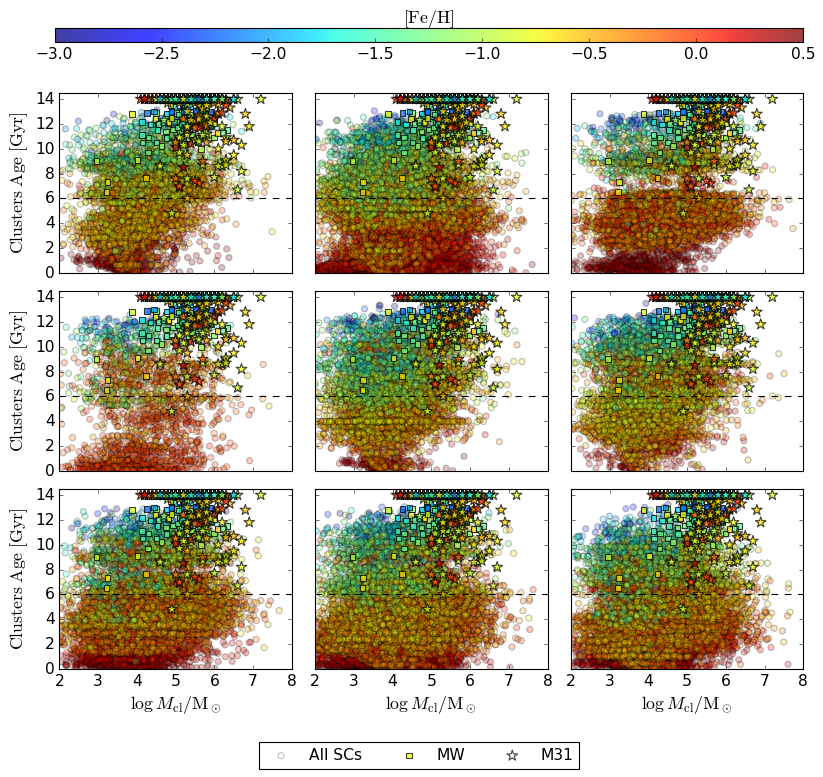

In [12]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(12,9))

for i in range(3):
    for j in range(3):
        idx = i*3 + j 
        if idx < len(simulation_list):
            ax[i,j].scatter(np.log10(masses_all[idx]), ages_all[idx], c=mettalicity_all[idx], edgecolors='k', marker='o', s=30, alpha=0.25, vmin=-3., vmax=0.5, label='All SCs', rasterized=True)
            ax[i,j].scatter(mw_masses, mw_age, c=mw_metallicity, edgecolors='k', marker='s', alpha=0.75, s=25, vmin=-3., vmax=0.5, label='MW', rasterized=True)
            cb=ax[i,j].scatter(m31_masses, m31_age, c=m31_metallicity, alpha=0.75, s=100, edgecolors='k', marker='*', vmin=-3., vmax=0.5, label='M31', rasterized=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=14)
            ax[i,j].hlines(6,2,8, color='k', linestyle='--')

for i in range(3):
    ax[i,0].set_ylabel(r'$\rm{Clusters}\; \rm{Age}\; [\rm{Gyr}]$', fontsize=16)
    ax[2,i].set_xlabel(r'$\log M_\mathrm{cl}/\mathrm{M}_\odot$',fontsize=16)


ax[0,0].set(xlim=(2,8), ylim=(0,14.5))
cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.97, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$[\rm{Fe/H}]$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Collect handles and labels from all axes (including twin axes) except the last one
handles = []
labels = []
for a in fig.axes:
    # if a is ax_last:
    #     continue
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Keep unique labels in order
seen = set()
unique_handles = []
unique_labels = []
for h, l in zip(handles, labels):
    if l and l not in seen:
        seen.add(l)
        unique_handles.append(h)
        unique_labels.append(l)

fig.legend(unique_handles, unique_labels, loc='center', bbox_to_anchor=(0.5, -0.02), frameon=True, ncol=3, scatterpoints=1, fontsize=14)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('plots/mass_age_met_allscs.pdf', bbox_inches='tight')

In [7]:
masses_sph = []
mettalicity_sph = []
ages_sph = []

snapshot = 127
for sim in simulation_list:
    mass, age, metallicity = get_mass_age_metallicity(parent_dir+sim+'/output/', snapshot=snapshot, decomposition=True)
    masses_sph.append(mass)
    mettalicity_sph.append(metallicity)
    ages_sph.append(age)

galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.021988682
Found 1937847 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.020834247
Found 1527247 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


galrad= 0.024249291
Found 1704041 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.024267228
Found 1735362 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.02422835
Found 2664011 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.025470624
Found 2678961 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.024573132
Found 2686170 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00


/tmp/ipykernel_413227/3628536317.py:7: RuntimeWarning: divide by zero encountered in log10
  ax[i,j].scatter(np.log10(masses_sph[idx]), ages_sph[idx], c=mettalicity_sph[idx], edgecolors='k', marker='o', s=30, alpha=0.25, vmin=-3., vmax=0.5, label='Spheroid SCs', rasterized=True)


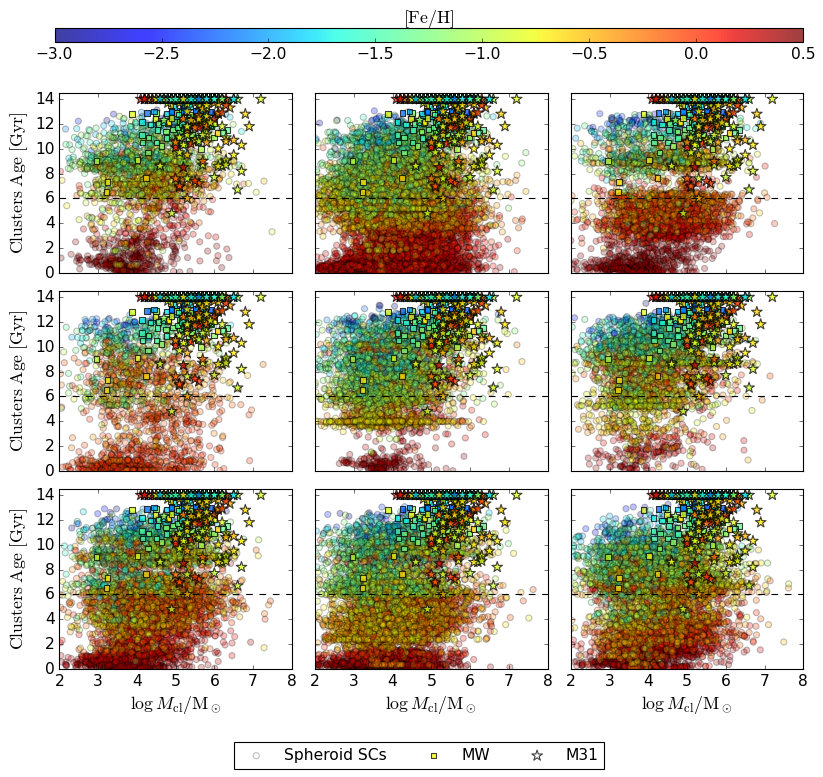

In [11]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(12,9))

for i in range(3):
    for j in range(3):
        idx = i*3 + j 
        if idx < len(simulation_list):
            ax[i,j].scatter(np.log10(masses_sph[idx]), ages_sph[idx], c=mettalicity_sph[idx], edgecolors='k', marker='o', s=30, alpha=0.25, vmin=-3., vmax=0.5, label='Spheroid SCs', rasterized=True)
            ax[i,j].scatter(mw_masses, mw_age, c=mw_metallicity, edgecolors='k', marker='s', alpha=0.75, s=25, vmin=-3., vmax=0.5, label='MW', rasterized=True)
            cb=ax[i,j].scatter(m31_masses, m31_age, c=m31_metallicity, alpha=0.75, s=100, edgecolors='k', marker='*', vmin=-3., vmax=0.5, label='M31', rasterized=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=14)
            ax[i,j].hlines(6,2,8, color='k', linestyle='--')

for i in range(3):
    ax[i,0].set_ylabel(r'$\rm{Clusters}\; \rm{Age}\; [\rm{Gyr}]$', fontsize=16)
    ax[2,i].set_xlabel(r'$\log M_\mathrm{cl}/\mathrm{M}_\odot$',fontsize=16)


ax[0,0].set(xlim=(2,8), ylim=(0,14.5))
cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.97, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$[\rm{Fe/H}]$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Collect handles and labels from all axes (including twin axes) except the last one
handles = []
labels = []
for a in fig.axes:
    # if a is ax_last:
    #     continue
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Keep unique labels in order
seen = set()
unique_handles = []
unique_labels = []
for h, l in zip(handles, labels):
    if l and l not in seen:
        seen.add(l)
        unique_handles.append(h)
        unique_labels.append(l)

fig.legend(unique_handles, unique_labels, loc='center', bbox_to_anchor=(0.5, -0.02), frameon=True, ncol=3, scatterpoints=1, fontsize=14)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('plots/mass_age_met_spheroid.pdf', bbox_inches='tight')

In [9]:
masses_gcs = []
mettalicity_gcs = []
ages_gcs = []

snapshot = 127
for sim in simulation_list:
    mass, age, metallicity = get_mass_age_metallicity(parent_dir+sim+'/output/', snapshot=snapshot, decomposition=True, init_mass_cut=True)
    masses_gcs.append(mass)
    mettalicity_gcs.append(metallicity)
    ages_gcs.append(age)

galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.021988682
Found 1937847 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.020834247
Found 1527247 stars.
Rotated pos.
Rotated vel.
Redshift of the simulation: 0.00


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


galrad= 0.024249291
Found 1704041 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.024267228
Found 1735362 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.02422835
Found 2664011 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.025470624
Found 2678961 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00
galrad= 0.024573132
Found 2686170 stars.
Rotated pos.
Rotated vel.


/tmp/ipykernel_413227/1577084964.py:13: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )


Redshift of the simulation: 0.00


/tmp/ipykernel_413227/279892557.py:7: RuntimeWarning: divide by zero encountered in log10
  ax[i,j].scatter(np.log10(masses_gcs[idx]), ages_gcs[idx], c=mettalicity_gcs[idx], edgecolors='k', marker='o', s=30, alpha=0.25, vmin=-3., vmax=0.5, label='GCs selection', rasterized=True)


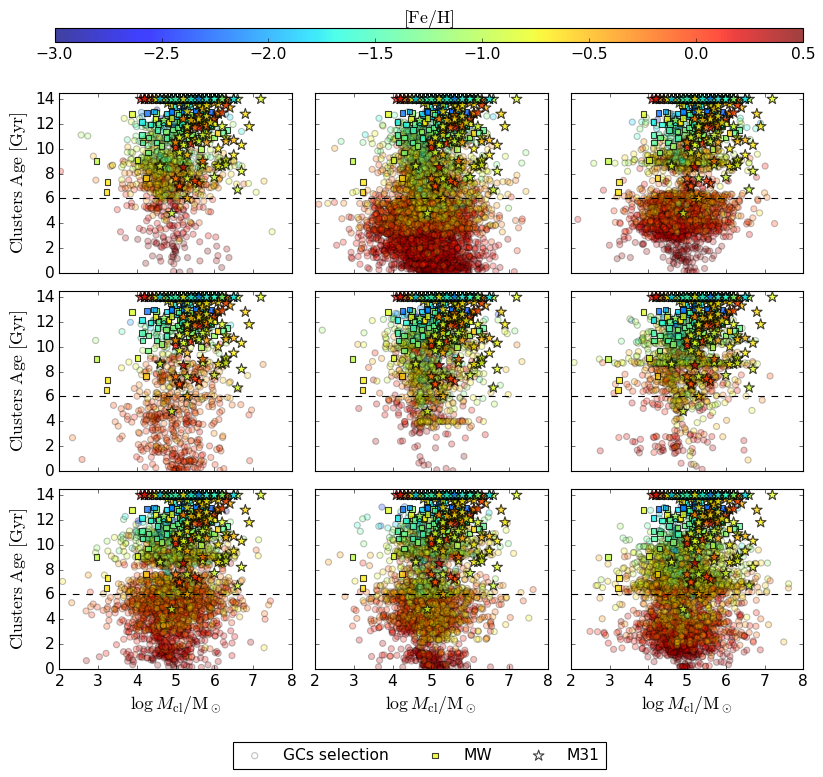

In [13]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(12,9))

for i in range(3):
    for j in range(3):
        idx = i*3 + j 
        if idx < len(simulation_list):
            ax[i,j].scatter(np.log10(masses_gcs[idx]), ages_gcs[idx], c=mettalicity_gcs[idx], edgecolors='k', marker='o', s=30, alpha=0.25, vmin=-3., vmax=0.5, label='GCs selection', rasterized=True)
            ax[i,j].scatter(mw_masses, mw_age, c=mw_metallicity, edgecolors='k', marker='s', alpha=0.75, s=25, vmin=-3., vmax=0.5, label='MW', rasterized=True)
            cb=ax[i,j].scatter(m31_masses, m31_age, c=m31_metallicity, alpha=0.75, s=100, edgecolors='k', marker='*', vmin=-3., vmax=0.5, label='M31', rasterized=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=14)
            ax[i,j].hlines(6,2,8, color='k', linestyle='--')

for i in range(3):
    ax[i,0].set_ylabel(r'$\rm{Clusters}\; \rm{Age}\; [\rm{Gyr}]$', fontsize=16)
    ax[2,i].set_xlabel(r'$\log M_\mathrm{cl}/\mathrm{M}_\odot$',fontsize=16)


ax[0,0].set(xlim=(2,8), ylim=(0,14.5))
cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 0.97, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$[\rm{Fe/H}]$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Collect handles and labels from all axes (including twin axes) except the last one
handles = []
labels = []
for a in fig.axes:
    # if a is ax_last:
    #     continue
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Keep unique labels in order
seen = set()
unique_handles = []
unique_labels = []
for h, l in zip(handles, labels):
    if l and l not in seen:
        seen.add(l)
        unique_handles.append(h)
        unique_labels.append(l)

fig.legend(unique_handles, unique_labels, loc='center', bbox_to_anchor=(0.5, -0.02), frameon=True, ncol=3, scatterpoints=1, fontsize=14)

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('plots/mass_age_met_gcsel.pdf', bbox_inches='tight')